<a href="https://colab.research.google.com/github/APre203/MLTopic1/blob/main/NN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install pydub

In [6]:
import os
import pathlib
import subprocess

import numpy as np
import pandas as pd
from scipy.io import wavfile

import argparse

import librosa
import librosa.feature
import soundfile as sf
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import json

In [40]:
csv_file = "/content/drive/MyDrive/stuttering_clips/fluencybank_labels.csv" #create dataframe for testing file
sep_file = "/content/drive/MyDrive/stuttering_clips/SEP-28k_labels.csv"
csv_df = pd.read_csv(csv_file, delimiter=",", encoding='utf-8')
sep_df = pd.read_csv(sep_file, delimiter=",", encoding='utf-8')

new_df = pd.concat([csv_df, sep_df], ignore_index=True)

csv_df = new_df

csv_df = csv_df.drop(['Start','Stop'],axis=1)

# print(len(csv_df))

32321


### MFCC AND MEL_SPECT

In [2]:
def mel_spectrogram(y, sr):
  mel_spect = librosa.feature.melspectrogram(y=y,sr=sr, n_mels=64)
  return mel_spect
def mfcc_converter(y,sr, n_fft=2048, hop_length=512, n_mfcc=13):
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
  # mfcc_scaled = np.mean(mfcc.T, axis=0)
  mfcc = mfcc.T
  # print(mfcc_scaled.shape)
  # print(mfcc.shape)
  return mfcc

### Creating the DataSet

In [ ]:
from pandas._libs.lib import count_level_2d
import json

SAMPLERATE = 16000
SPECSHAPE = (64,94)
MFCCSHAPE = (13,)

JSON_PATH = "data.json"
JSON_TEST_PATH = "data_t.json"

def file_to_df(csv, num):
  test= int(num*0.2)
  data = {
      "Prolongation":[],
      "WordRep":[],
      "SoundRep":[],
      "Block":[],
      "Interjection":[],
      "Stutter":[],
      "spect":[],
      "mfcc":[],
      "total":[] #0 -> Stutter, 1 -> Prolongation, 2 -> WordRep, 3 -> SoundRep, 4 -> Block, 5 -> Interjection
  }
  test_data = {
      "Prolongation":[],
      "WordRep":[],
      "SoundRep":[],
      "Block":[],
      "Interjection":[],
      "Stutter":[],
      "spect":[],
      "mfcc":[],
      "total":[] #0 -> Stutter, 1 -> Prolongation, 2 -> WordRep, 3 -> SoundRep, 4 -> Block, 5 -> Interjection
  }
  #/content/drive/MyDrive/stuttering_clips/clips/stuttering-clips/clips/FluencyBank_010_0.wav
  # new_df = pd.DataFrame(columns=csv_df.columns)
  i = 0
  count = 0
  test_c = 0
  json_c = False
  for index, row in csv.iterrows():
    # find each wav file
    if count > num and test_c > test:
      break
    else:
      path_name = f'{row["Show"]}_{row["EpId"]}_{row["ClipId"]}.wav'
      p = f'/content/drive/MyDrive/stuttering_clips/clips/stuttering-clips/clips/'
      try:
        y, sr = sf.read(p + path_name)
        count += 1
      except:
        i+=1
        continue

      # print(count)
      # calculate spectro and mfcc for the wav fiel
      spectro = mel_spectrogram(y,sr)
      mfcc = mfcc_converter(y,sr)
      if spectro.shape != SPECSHAPE:
        continue
      else:
        if count > num:
          if not json_c:
            json_c = True
            with open(JSON_PATH, "w") as fp:
              # print(data)
              json.dump(data, fp, indent=4)
          data = test_data
        if row["Prolongation"] > 1 or row["WordRep"] > 1 or row["SoundRep"] > 1 or row["Block"] > 1 or row["Interjection"] > 1: # means they stuttered #row["NoStutteredWords"] >= 2:
          if row["Prolongation"] > 1:
            data["Prolongation"].append(1)
            data["Interjection"].append(0)
            data["Block"].append(0)
            data["SoundRep"].append(0)
            data["WordRep"].append(0)
            data["total"].append(1)
          elif row["WordRep"] > 1:
            data["WordRep"].append(1)
            data["Interjection"].append(0)
            data["Block"].append(0)
            data["SoundRep"].append(0)
            data["Prolongation"].append(0)
            data["total"].append(2)
          elif row["SoundRep"] > 1:
            data["SoundRep"].append(1)
            data["Interjection"].append(0)
            data["Block"].append(0)
            data["WordRep"].append(0)
            data["Prolongation"].append(0)
            data["total"].append(3)
          elif row["Block"] > 1:
            data["Block"].append(1)
            data["Interjection"].append(0)
            data["SoundRep"].append(0)
            data["WordRep"].append(0)
            data["Prolongation"].append(0)
            data["total"].append(4)
          else:
            data["Interjection"].append(1)
            data["Block"].append(0)
            data["SoundRep"].append(0)
            data["WordRep"].append(0)
            data["Prolongation"].append(0)
            data["total"].append(5)

          data["Stutter"].append(1) # did stutter
        else:
          data["Stutter"].append(0) # didnt stutter
          data["Interjection"].append(0)
          data["Block"].append(0)
          data["SoundRep"].append(0)
          data["WordRep"].append(0)
          data["Prolongation"].append(0)
          data["total"].append(0)

        data["spect"].append(spectro.tolist())
        data["mfcc"].append(mfcc.tolist())

        if count > num:
          test_data = data
          test_c += 1
        # print(count, test_c)
        # nn_df = pd.concat([new_df, row], ignore_index=True)

        # new_df = nn_df  # Append the new row to the new DataFrame
        # retval_df = new_df
        # new_df = new_df.append(row, ignore_index=True)  # Append the new row to the new DataFrame TRY CHANGEING IT TO pd.concat
        # retval_df = new_df

  print(f'Number of times failed: {i}')

  with open(JSON_TEST_PATH, "w") as fp:
    json.dump(test_data, fp, indent=4)
  return None

def balanced(df): # 0 -> didnt stutter -- 1 -> stutter
  count_stutter_0 = len(df[df["Stutter"] == 0])
  count_stutter_1 = len(df[df["Stutter"] == 1])
  number = min(count_stutter_0,count_stutter_1) # number of min(stutters,no-stutters)

  balanced_df_stutter_0 = df[df["Stutter"] == 0].sample(n=math.ceil(number))
  balanced_df_stutter_1 = df[df["Stutter"] == 1].sample(n=number)
  retval_balanced = pd.concat([balanced_df_stutter_0, balanced_df_stutter_1])



  print(f'Length of total df is: {2*number}')
  return retval_balanced

In [ ]:
csv_df = csv_df.sample(frac=1, random_state=42)
csv_sample = file_to_df(csv_df, 5000) #15000 of the wav files

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Number of times failed: 1577


In [ ]:
# balanced_dataset = balanced(csv_sample)
# balanced_dataset = balanced_dataset.sample(frac=1, random_state=42)

Length of total df is: 4892


### Using the data

In [7]:
def load_data(dataset_path): #Stutter,Prolongation,WordRep,SoundRep,Block,Interjection
  with open(dataset_path, "r") as fp:
    data = json.load(fp)
    #compare1, compare2
  compare1 = "mfcc"
  # compare2 = "SoundRep"
  # inputs = np.array(data[compare1])
  # targets = np.array(data[compare])
  return data

In [ ]:
from sklearn.model_selection import train_test_split
inputs, targets = load_data("data.json")

inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)

In [8]:
def plot_hist(hist):
  fig, axs = plt.subplots(2)
  # accuracy subplot
  axs[0].plot(hist.history["accuracy"], label="train accuracy")
  axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")


  # error subplot
  axs[1].plot(hist.history["loss"], label="train loss")
  axs[1].plot(hist.history["val_loss"], label="test loss")
  axs[1].set_ylabel("Loss")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Loss eval")

  plt.show()


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

data = load_data("data.json")
def make_model(compare):

  inputs = np.array(data["mfcc"])
  targets = np.array(data[compare])

  inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)

  yt_model = Sequential([
      Flatten(input_shape=(inputs.shape[1],inputs.shape[2])),

      # 1st Hidden Layer
      Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
      Dropout(0.3),

      # 2nd Hidden Layer
      Dense(256, activation="relu", kernel_regularizer=l2(0.01)),
      # Dropout(0.3),
      # 3rd Hidden Layer
      Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
      # Dropout(0.3),
      Dense(32, activation="relu", kernel_regularizer=l2(0.001)),

      Dense(2, activation="softmax")

  ])

  optimizer = Adam(learning_rate=0.001)
  yt_model.compile(optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

  yt_model.summary()

  hist = yt_model.fit(inputs_train, targets_train, validation_data=(inputs_test,targets_test), epochs=100, batch_size=64)
  return yt_model, hist

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1222)              0         
                                                                 
 dense (Dense)               (None, 512)               626176    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 6

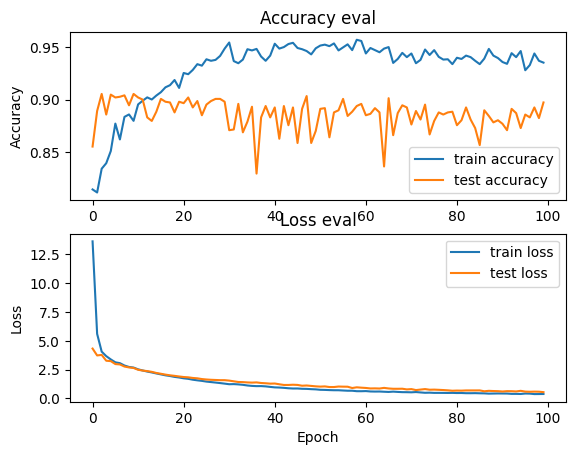

In [12]:
model_prol, hist = make_model("Prolongation") #Stutter,Prolongation,WordRep,SoundRep,Block,Interjection
plot_hist(hist)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1222)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               626176    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 2)                

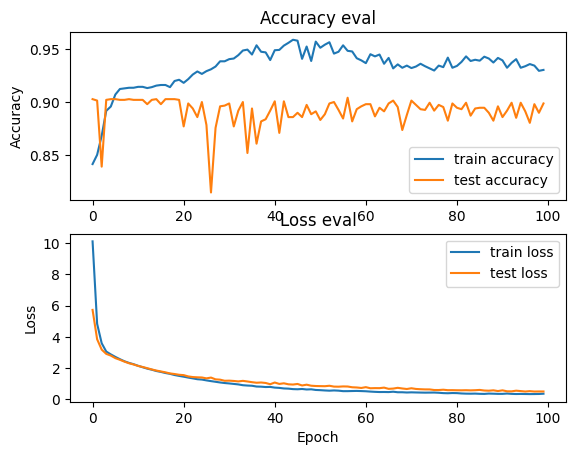

In [13]:
model_word, hist = make_model("WordRep") #Stutter,Prolongation,WordRep,SoundRep,Block,Interjection
plot_hist(hist)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 1222)              0         
                                                                 
 dense_40 (Dense)            (None, 512)               626176    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_41 (Dense)            (None, 256)               131328    
                                                                 
 dense_42 (Dense)            (None, 64)                16448     
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dense_44 (Dense)            (None, 2)                

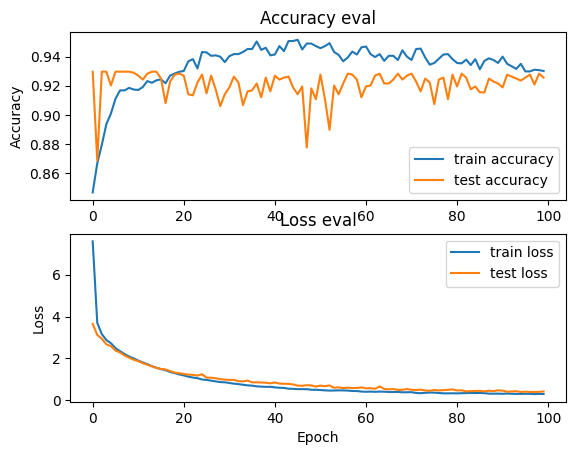

In [23]:
model_sound, hist = make_model("SoundRep") #Stutter,Prolongation,WordRep,SoundRep,Block,Interjection
plot_hist(hist)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 1222)              0         
                                                                 
 dense_30 (Dense)            (None, 512)               626176    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 64)                16448     
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 2)                

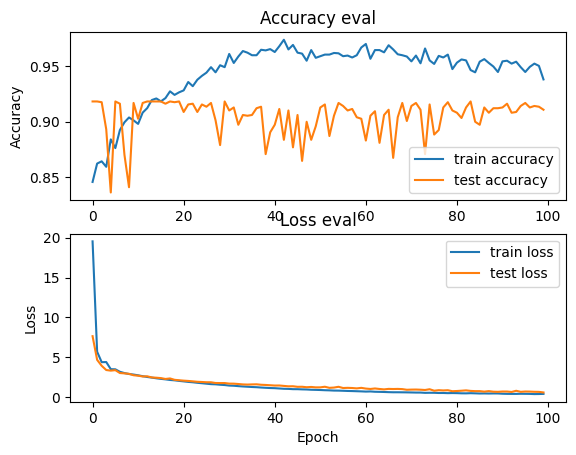

In [21]:
model_block, hist = make_model("Block") #Stutter,Prolongation,WordRep,SoundRep,Block,Interjection
plot_hist(hist)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1222)              0         
                                                                 
 dense_25 (Dense)            (None, 512)               626176    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dense_27 (Dense)            (None, 64)                16448     
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 2)                

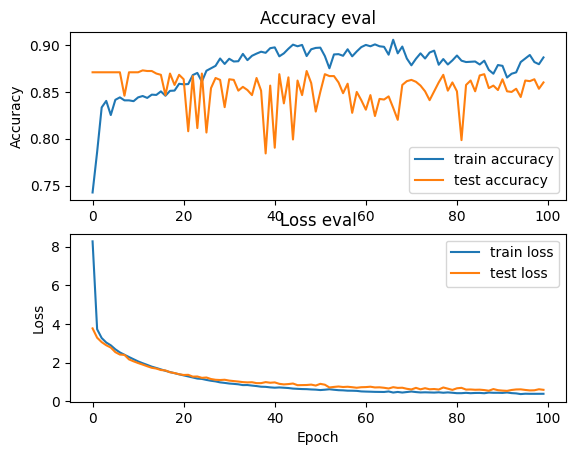

In [20]:
model_inter, hist = make_model("Interjection") #Stutter,Prolongation,WordRep,SoundRep,Block,Interjection
plot_hist(hist)

In [17]:
data_t = load_data("data_t.json")


In [18]:
def zeroone(array):
  if array[0] > 0.5:
    return 0
  return 1


In [24]:
# print(inputs.shape)
# model_prol , model_word , model_sound , model_block , model_inter
#Stutter,Prolongation,WordRep,SoundRep,Block,Interjection
inputs = np.array(data_t["mfcc"])
targets = np.array(data_t["Prolongation"])
tp, tw, ts, tb, ti, tstutter = np.array(data_t["Prolongation"]), np.array(data_t["WordRep"]), np.array(data_t["SoundRep"]), np.array(data_t["Block"]), np.array(data_t["Interjection"]), np.array(data_t["Stutter"])
predicted_prol = model_prol.predict(inputs)
predicted_word = model_word.predict(inputs)
predicted_sound = model_sound.predict(inputs)
predicted_block= model_block.predict(inputs)
predicted_inter = model_inter.predict(inputs)

cp,cw,cs,cb,ci,cstut = 0,0,0,0,0,0

for pp,pw,ps,pb,pi,p,w,s,b,i, stut in zip(predicted_prol, predicted_word,predicted_sound,predicted_block,predicted_inter, tp, tw, ts, tb, ti, tstutter):
  pp,pw,ps,pb,pi = zeroone(pp),zeroone(pw),zeroone(ps),zeroone(pb),zeroone(pi)

  if pp == p:
    cp += 1
  if pw == w:
    cw += 1
  if ps == s:
    cs += 1
  if pb == b:
    cb += 1
  if pi == i:
    ci += 1

  if pp == 0 and pw == 0 and ps == 0 and pb == 0 and pi == 0 and stut == 0:
    cstut += 1
  # sutter = pp or pw or ps or pb or pi

  # if sutter == r:
  #   correct += 1

print(f"Prolongation: {cp / len(targets)}")
print(f"WordRep: {cw / len(targets)}")
print(f"SoundRep: {cs / len(targets)}")
print(f"Block: {cb / len(targets)}")
print(f"Interjection: {ci / len(targets)}")
print(f"Stutter: {cstut / len(targets)}")


32/32 [==============================] - 0s 2ms/step
Prolongation: 0.8911088911088911
WordRep: 0.9080919080919081
SoundRep: 0.9230769230769231
Block: 0.8961038961038961
Interjection: 0.8581418581418582
Stutter: 0.46353646353646355
